In [108]:
import os
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter, PercentFormatter
import seaborn as sns

data_dir = os.path.normpath(os.path.join(os.path.abspath(''), '..', 'data'))
graphs_dir = os.path.normpath(os.path.join(
    os.path.abspath(''), '..', 'graphs'))

default_figsize_x, default_figsize_y = plt.rcParams["figure.figsize"]

sns.reset_defaults()
sns.set_theme(context="paper", font="FiraGO",
              font_scale=1.1, palette="colorblind")
plt.ion()


In [12]:
interesting_genres = [
    "Art & Design",
    "Auto & Vehicles",
    "Beauty",
    "Books & Reference",
    "Business",
    "Communication",
    "Dating",
    "Education",
    "Entertainment",
    "Events",
    "Finance",
    "Food & Drink",
    "Health & Fitness",
    "House & Home",
    "Lifestyle",
    "Maps & Navigation",
    "Medical",
    "Music & Audio",
    "News & Magazines",
    "Parenting",
    "Personalization",
    "Photography",
    "Productivity",
    "Shopping",
    "Social",
    "Sports",
    "Tools",
    "Travel & Local",
    "Video Players & Editors",
    "Weather",
]

type_renamer = lambda t: t.replace('_', ' ')
type_order = ["data collected", "data shared"]

data_type_renames = {
    'app_id': 'app ID',
    'os': 'OS version',
    'other_uuids': 'other UUIDs',
    'idfa': 'advertising ID',
    'rooted': 'rooted?',
    'ram_usage': 'RAM usage',
    'is_charging': 'is charging?',
    'emulator': 'emulator?',
    'local_ips': 'local IPs',
    'hashed_idfa': 'hashed advertising ID',
    'in_foreground': 'in foreground?',
    'bssid': 'BSSID'
}
def data_type_renamer(d): return (
    data_type_renames[d] if d in data_type_renames else d.replace('_', ' '))


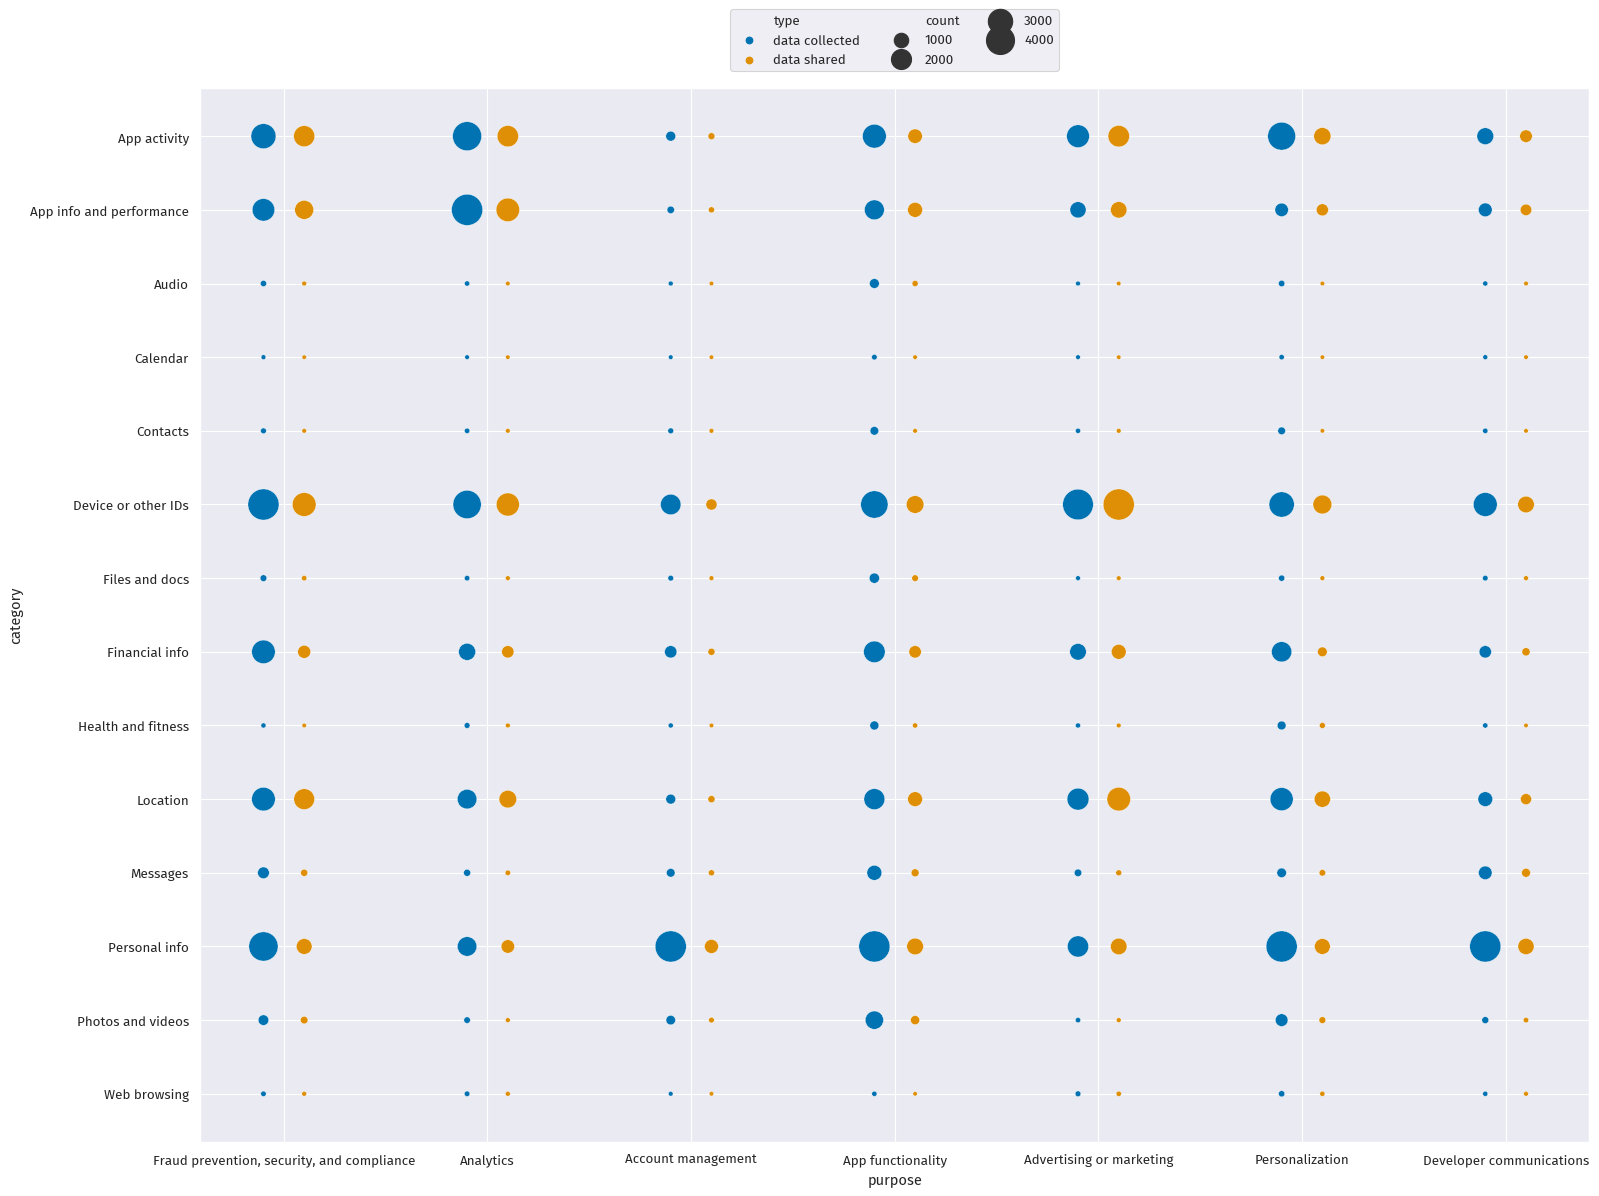

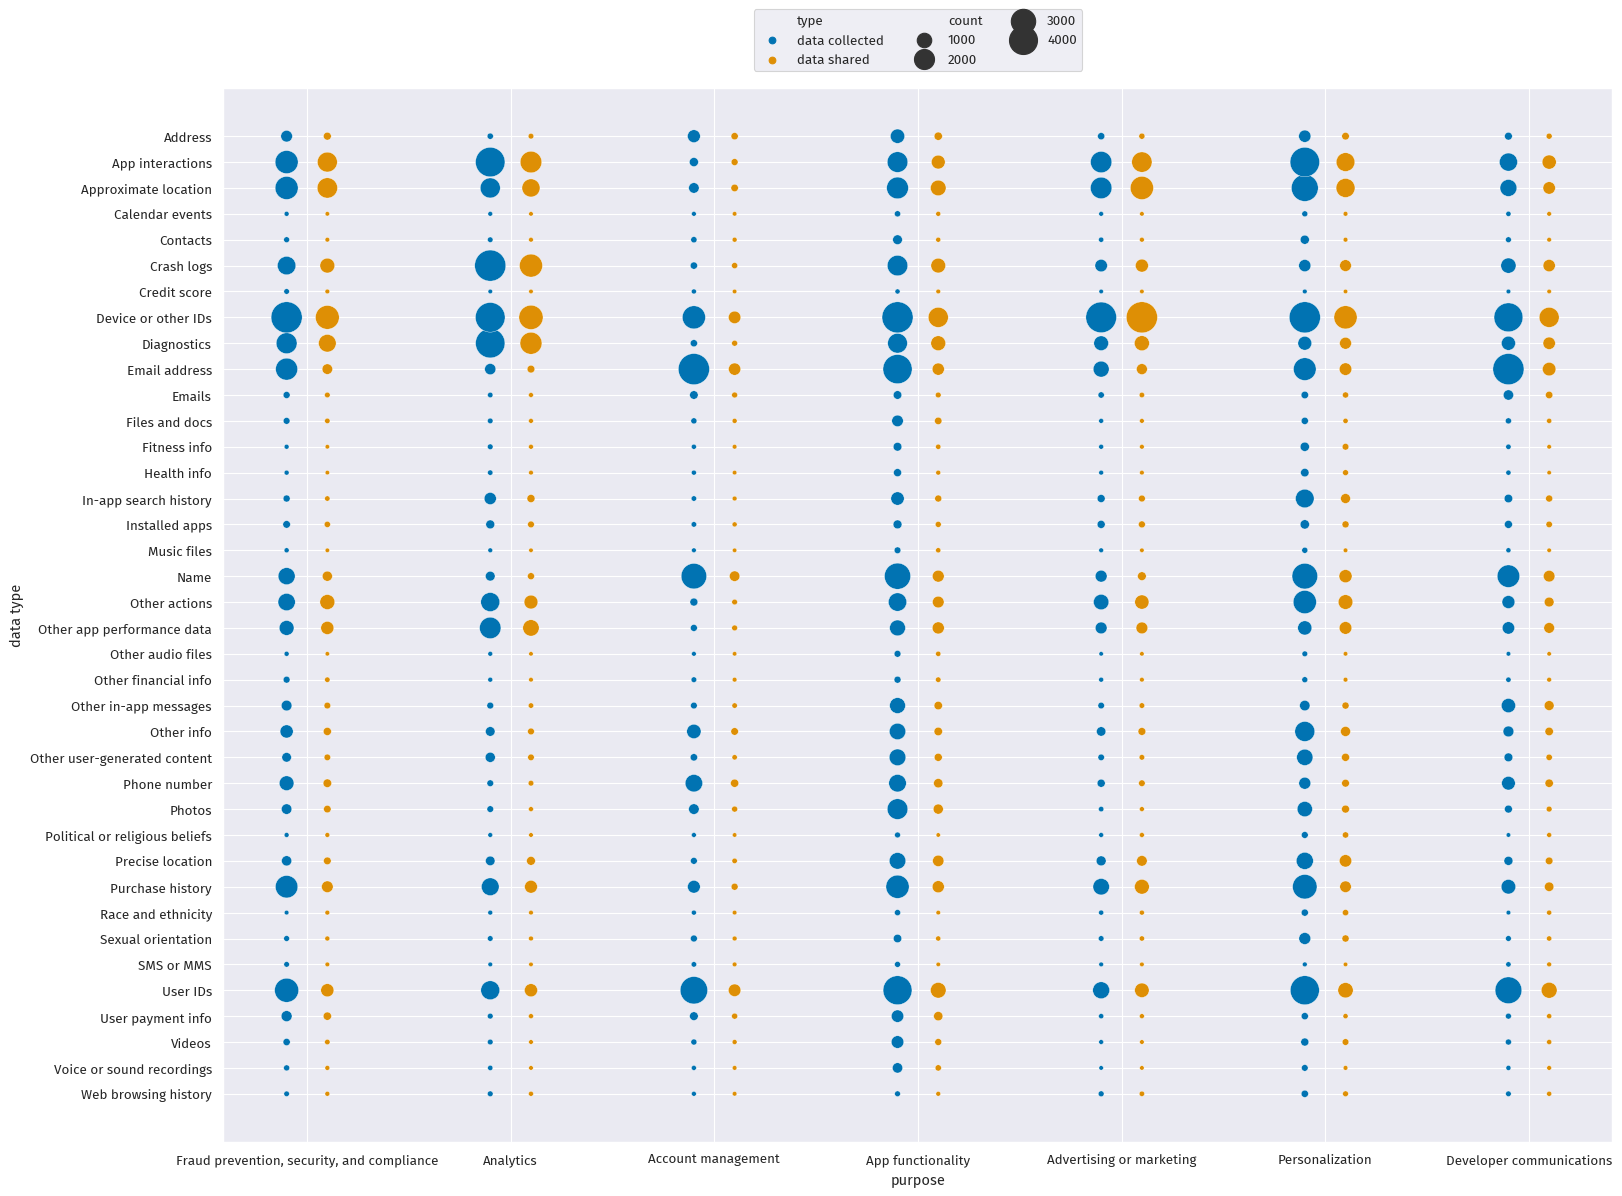

In [113]:
for attribute in ['category', 'data_type']:
    csv = pd.read_csv(os.path.join(
        data_dir, f'declared_{attribute}_purpose_counts.csv'), converters={"type": type_renamer}, on_bad_lines='error')
    ordered_data_types = sorted(csv[attribute].unique(), key=str.lower)
    csv[attribute] = pd.Categorical(
        csv[attribute], categories=ordered_data_types, ordered=True)

    x_labels = csv['purpose'].unique()

    fig, ax = plt.subplots(
        figsize=[2.8*default_figsize_x, 2.85*default_figsize_y])

    for i, label in enumerate(x_labels):
        rows = csv.loc[csv['purpose'] == label]

        x = [i + (-0.1 if platform == 'data collected' else 0.1)
                for platform in rows['type']]
        sns.scatterplot(x=x, y=attribute, size="count", sizes=(10, 500), hue="type", hue_order=['data collected', 'data shared'],
                        data=rows, ax=ax, legend=i == 0)

    sns.move_legend(ax, "lower center",
                    bbox_to_anchor=(.5, 1.01), ncol=3)

    ax.set_xticks(range(0, len(x_labels)))
    ax.set_xticklabels(x_labels)

    ax.set_xlabel('purpose')
    ax.set_ylabel(attribute.replace('_', ' '))

    fig.savefig(os.path.join(graphs_dir, f'declaration_matrix_{attribute}.svg'),
                bbox_inches="tight", pad_inches=0)


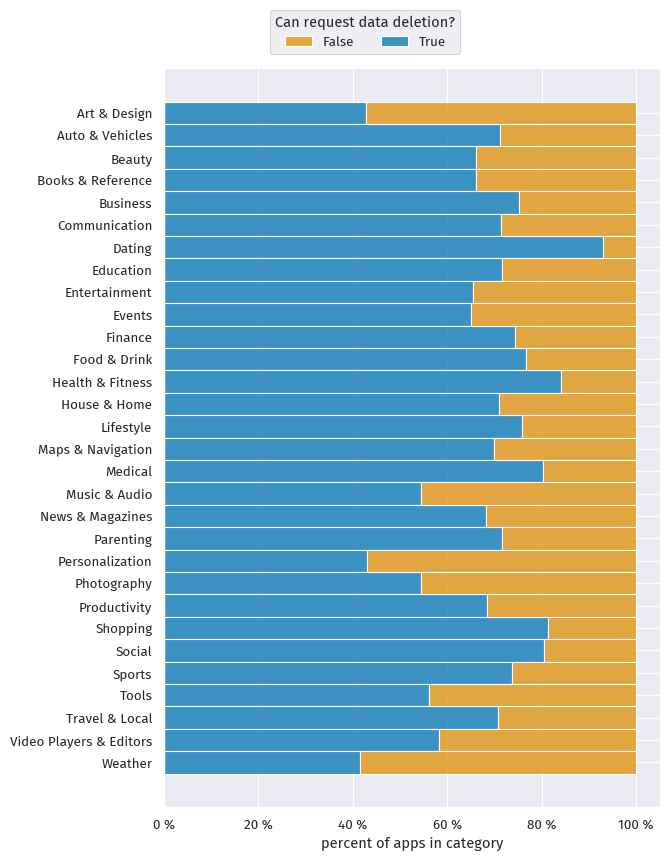

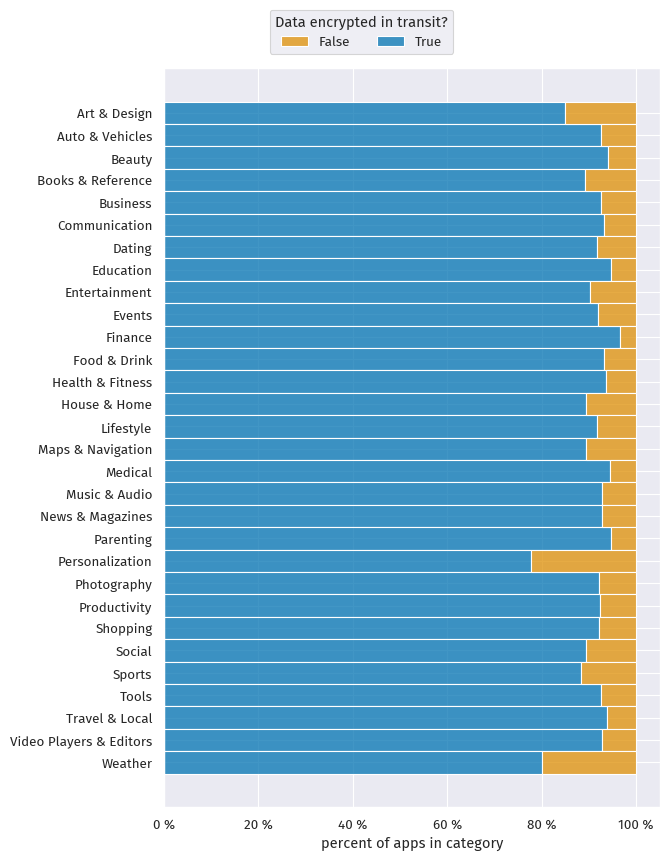

In [114]:
for attribute in ['can_request_data_deletion', 'data_encrypted_in_transit']:
    csv = pd.read_csv(os.path.join(
        data_dir, 'security_practices.csv'), on_bad_lines='error')
    csv = csv.loc[csv['genre'].isin(interesting_genres)]
    # Normalize each bar, https://stackoverflow.com/a/59433700
    csv = csv.groupby('genre')[attribute].value_counts(
        normalize=True).mul(100).rename('percent')
    csv = csv.reset_index()

    fig, ax = plt.subplots(figsize=[default_figsize_x, 2*default_figsize_y])
    # https://www.pythoncharts.com/python/stacked-bar-charts/
    sns.histplot(y="genre", hue=attribute, hue_order=[False, True], palette=[sns.color_palette()[i] for i in [1, 0]],
                    weights="percent", multiple="stack", data=csv, ax=ax)
    
    ax.set_ylabel("")
    ax.set_xlabel("percent of apps in category")
    ax.get_xaxis().set_major_formatter(PercentFormatter(symbol=' %'))
    sns.move_legend(ax, "lower left", title="Can request data deletion?" if attribute == "can_request_data_deletion" else "Data encrypted in transit?", bbox_to_anchor=(0.2, 1.01), ncol=2)

    fig.savefig(os.path.join(graphs_dir, f'{attribute}.svg'),
                bbox_inches="tight", pad_inches=0)


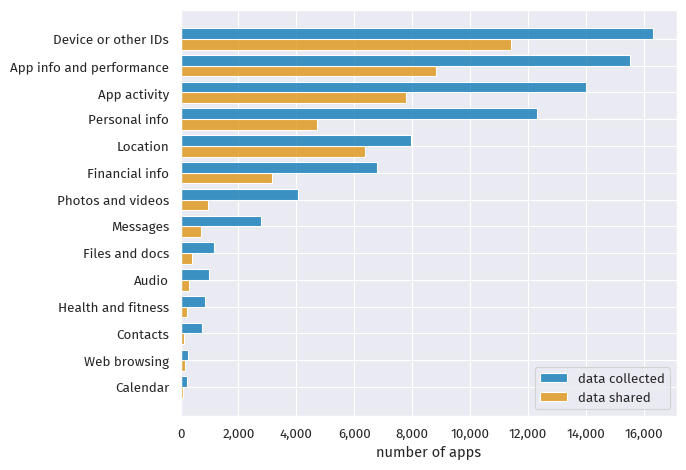

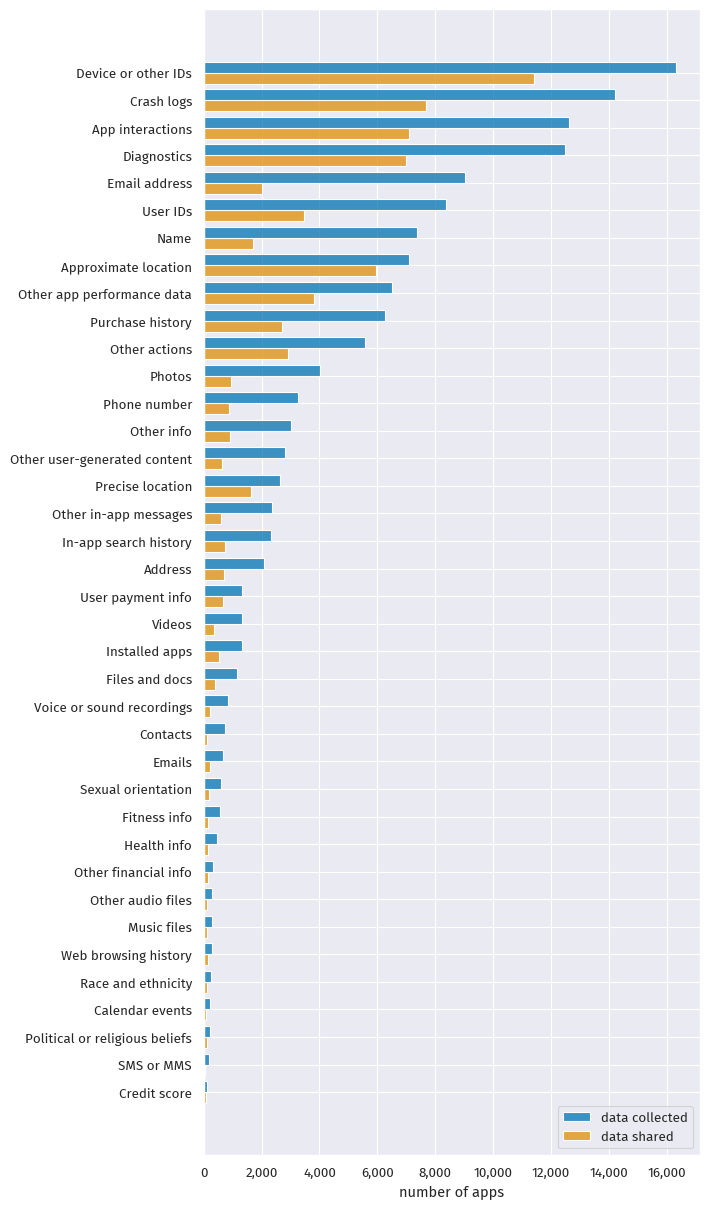

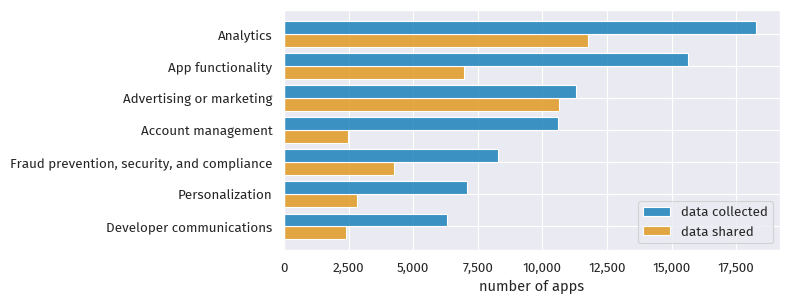

In [31]:
params = {
    "category": {"height": 1.1, "title": "Apps collecting or sharing data from each category\naccording to their data safety label"},
    "data_type": {"height": 3.1, "title": "Apps collecting or sharing each data type\naccording to their data safety label"},
    "purpose": {"height": 0.65, "title": "Apps collecting or sharing data for each purpose\naccording to their data safety label"},
}

for attribute in ['category', 'data_type', 'purpose']:
    csv = pd.read_csv(os.path.join(
        data_dir, f'declared_{attribute}_counts.csv'), converters={"type": type_renamer}, on_bad_lines='error').sort_values(by=["count"], ascending=False)

    fig, ax = plt.subplots(figsize=[default_figsize_x, params[attribute]["height"]*default_figsize_y])
    ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    # https://www.pythoncharts.com/python/stacked-bar-charts/
    sns.histplot(y=attribute, hue="type", hue_order=type_order, palette="colorblind",
                 weights="count", multiple="dodge", shrink=0.8, data=csv, ax=ax)

    # ax.set_title(params[attribute]["title"])
    ax.set_xlabel("number of apps")
    ax.set_ylabel("")

    sns.move_legend(ax, "lower right", title="")

    fig.savefig(os.path.join(graphs_dir, f'label_{attribute}_counts.svg'),
                bbox_inches="tight", pad_inches=0, transparent=True)


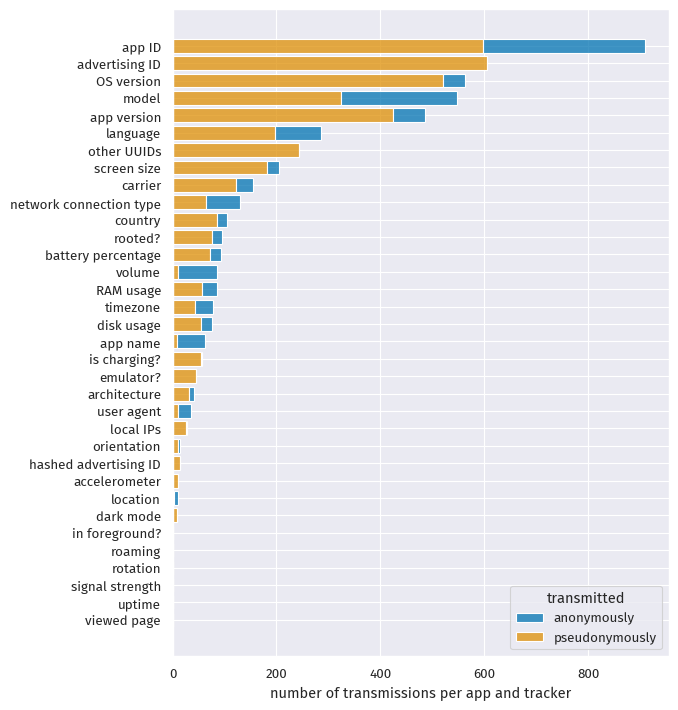

In [89]:
csv = pd.read_csv(os.path.join(
    data_dir, f'apps_trackers_data_types.csv'), on_bad_lines='error', converters={'data_type': data_type_renamer}).sort_values(by=['data_type'])
csv['data_type'] = pd.Categorical(
    csv['data_type'], categories=csv['data_type'].value_counts().keys(), ordered=True)

fig, ax = plt.subplots(figsize=[default_figsize_x, 1.75*default_figsize_y])
sns.histplot(y="data_type", hue="transmission_type", multiple="stack", hue_order=[
    'anonymously', 'pseudonymously'], shrink=0.8, data=csv, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('number of transmissions per app and tracker')
sns.move_legend(ax, "lower right", title='transmitted')

fig.savefig(os.path.join(graphs_dir, 'traffic_data_types.svg'),
            bbox_inches="tight", pad_inches=0, transparent=True)


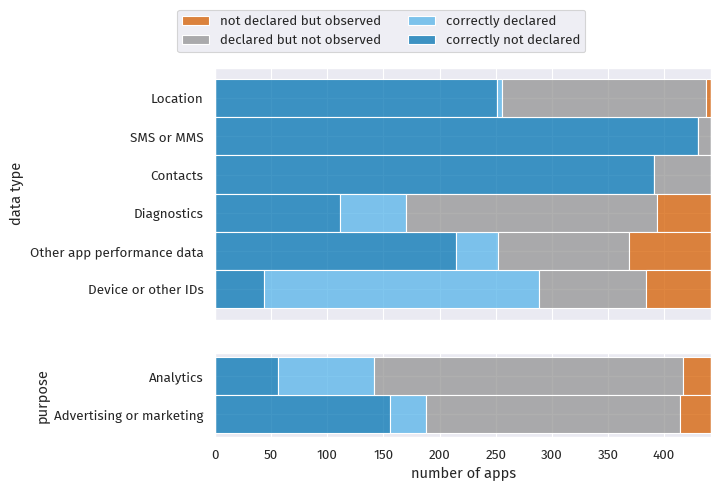

In [90]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True,
                         gridspec_kw={'height_ratios': [6, 2]})


def declared_renamer(d): return {'wrongly_undeclared': 'not declared but observed', 'correctly_declared': 'correctly declared',
                                 'unnecessarily_declared': 'declared but not observed', 'correctly_undeclared': 'correctly not declared'}[d]


def purpose_renamer(p): return {
    'tracking': 'Analytics', 'ads': 'Advertising or marketing'}[p]


csv = pd.read_csv(os.path.join(
    data_dir, 'data_type_truthfulness.csv'), on_bad_lines='error', converters={'declared': declared_renamer})

hue_order = ['not declared but observed',
             'declared but not observed',
             'correctly declared',
             'correctly not declared']
palette = [sns.color_palette()[i] for i in [3, 7, 9, 0]]

sns.histplot(y="data_type", hue="declared", hue_order=hue_order, palette=palette,
             multiple="stack", data=csv, ax=axes[0], legend=False)
axes[0].set_ylabel('data type')
axes[0].set_xlim(0, len(csv['app'].unique()))

csv = pd.read_csv(os.path.join(
    data_dir, 'purpose_truthfulness.csv'), on_bad_lines='error', converters={'declared': declared_renamer, 'purpose': purpose_renamer})
sns.histplot(y="purpose", hue="declared", hue_order=hue_order, palette=palette,
             multiple="stack", data=csv, ax=axes[1])
axes[1].set_xlabel('number of apps')
sns.move_legend(axes[1], "lower center",
                bbox_to_anchor=(.335, 4.5), ncol=2, title=None)

fig.savefig(os.path.join(graphs_dir, 'label_truthfulness.svg'),
            bbox_inches="tight", pad_inches=0, transparent=True)
